# 결측치 및 이상치 제거 코드

In [43]:
import pandas as pd
import numpy as np
pd.set_option('max_columns',999)
pd.set_option('max_rows',200)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
sns.set() 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 
sns.set_style(style='white')
sns.set_context(context ='paper')

import datetime
import os
from functools import reduce
import json

In [44]:
# Data for training loaded from the database
projects = pd.read_csv('ks-projects-201801.csv')

In [45]:
projects.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### state 재정의
모금 금액이 목표 금액 이상이면 success, 미만이면 failed 

In [3]:
projects['state_new'] = projects.apply(lambda x: 'success' if x['usd_pledged_real'] >= x['usd_goal_real']
                                       else 'failed', axis = 1)

### >> deadline & launched --> 펀딩 기간

In [4]:
projects['launched_year'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[0], axis = 1)
projects['launched_month'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1], axis = 1)
projects['launched_day'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[2], axis = 1)
projects['launched_date'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1] + x['launched'].split(" ")[0].split("-")[2], axis = 1)

In [5]:
projects['deadline_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['deadline'], "%Y-%m-%d").date(), axis = 1)
projects['launched_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['launched'].split(" ")[0], "%Y-%m-%d").date(), axis = 1)

In [6]:
projects['term'] = projects.apply(lambda x: int(str(x['deadline_dt'] - x['launched_dt']).split(" ")[0]), axis = 1)
projects['term_str'] = projects.apply(lambda x: str(x['term']), axis = 1)

In [7]:
projects.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_new,launched_year,launched_month,launched_day,launched_date,deadline_dt,launched_dt,term,term_str
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,failed,2015,08,11,0811,2015-10-09,2015-08-11,59,59
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,failed,2017,09,02,0902,2017-11-01,2017-09-02,60,60
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,failed,2013,01,12,0112,2013-02-26,2013-01-12,45,45
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,failed,2012,03,17,0317,2012-04-16,2012-03-17,30,30
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,failed,2015,07,04,0704,2015-08-29,2015-07-04,56,56


In [8]:
# launch 날짜가 1970년으로 되어있는 row는 삭제
projects_new = projects[lambda x: x['term'] < 100]

In [9]:
projects_new = projects_new.reset_index().drop(['index'], axis = 1)

In [10]:
projects_new['term_str'] = projects_new.apply(lambda x: x['term_str'] if len(x['term_str']) != 1
                                             else '0' + x['term_str'], axis = 1)

In [11]:
# binnarize the dependent variable
projects_new['state_bin'] = projects_new['state_new'].apply(lambda x: 0 if x == 'failed' else 1)

In [12]:
# 10만원 이하로 펀딩 받는 경우는 지움
projects_fin = projects_new[projects_new['usd_goal_real'] > 100]

In [13]:
projects_fin = projects_new[projects_new['country'].isin(['US', 'BR', 'CA', 'AU', 'DE', 'FR', 'IT', 'NL', 'ES'])]

In [14]:
projects_fin = projects_new[projects_new['currency'].isin(['USD', 'GBP', 'EUR', 'CAD', 'AUD'])]

# Processing the Data into a Trainable data

In [15]:
# Creating the dataset
train_data = projects_fin[['category', 'main_category', 'currency', 'country', 'usd_goal_real', 'state_bin', 'launched_year', 'launched_month', 'term']].copy()

In [16]:
train = pd.DataFrame()

In [17]:
# Assigning a categorical type to categorical varibles and vectorizing the categories for simplification
train['category'] = train_data['category'].astype('category').cat.codes
train['main_category'] = train_data['main_category'].astype('category').cat.codes
train['currency'] = train_data['currency'].astype('category').cat.codes
train['country'] = train_data['country'].astype('category').cat.codes

In [18]:
# export labes for vectorizing

cat_c = train_data['category'].astype('category')
main_c = train_data['main_category'].astype('category')
curre_c = train_data['currency'].astype('category')
count_c = train_data['country'].astype('category')
cat_d = dict(enumerate(cat_c.cat.categories))
main_d = dict(enumerate(main_c.cat.categories))
curre_d = dict(enumerate(curre_c.cat.categories))
count_d = dict(enumerate(count_c.cat.categories))

cat = {y:x for x,y in cat_d.items()}
main = {y:x for x,y in main_d.items()}
curre = {y:x for x,y in curre_d.items()}
count = {y:x for x,y in count_d.items()}

cat_labels = {'category' : cat, 'main_category' : main, 'currency' : curre, 'country': count}
cat_json = json.dumps(cat_labels)
f = open("cat_labels.json","w")
f.write(cat_json)
f.close()

In [19]:
train[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state']] = train_data[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state_bin']]

In [38]:
train['launched_year'] = (train['launched_year']).astype('int')
train['launched_month'] = (train['launched_month']).astype('int')

# Feature Selection
Result: all columns seems to be important

In [39]:
x = train.iloc[:,:-1]
y = train.iloc[:,-1]

In [42]:
train.dtypes

category            int16
main_category        int8
currency             int8
country              int8
usd_goal_real     float64
launched_year       int32
launched_month      int32
term                int64
state               int64
dtype: object

In [34]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [22]:
xgb_model = xgb.XGBClassifier(n_estimators=1000,
                        n_jobs=6,
                        max_depth=5,
                        learning_rate=0.1,
                        gamma = 0,
                        subsample = 0.8,
                        scale_pos_weight = 1,
                        min_child_weight=1,
                        colsample_bytree=0.8,
                        objective= 'binary:logistic',
                        nthread=4,
                        missing=-999,
                        seed=27,
                        tree_method='gpu_hist')

In [23]:
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=-999, n_estimators=1000, n_jobs=6,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)

In [24]:
prediction = xgb_model.predict(x_test)

In [30]:
from sklearn.metrics import accuracy_score, f1_score

In [26]:
f1_score(y_test, prediction), accuracy_score(y_test, prediction)

(0.5380832570905763, 0.7109114984074724)

<BarContainer object of 8 artists>

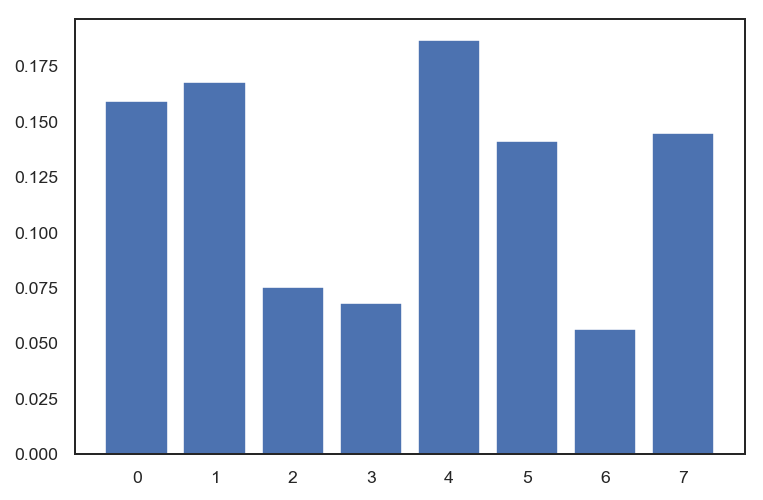

In [27]:
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)

# Comparison of Xgboost and Catboost
result: use catboost

In [23]:
import catboost as cb

In [24]:
cb_clf = cb.CatBoostClassifier(task_type = 'GPU')

In [27]:
# Labelling the categorical features
cat_features= [0,1,2,3]

cb_clf.fit(x_train, y_train, cat_features)

Learning rate set to 0.080728
0:	learn: 0.6756218	total: 47.4ms	remaining: 47.4s
1:	learn: 0.6610934	total: 93.2ms	remaining: 46.5s
2:	learn: 0.6486549	total: 142ms	remaining: 47.3s
3:	learn: 0.6383553	total: 183ms	remaining: 45.6s
4:	learn: 0.6300611	total: 223ms	remaining: 44.4s
5:	learn: 0.6227625	total: 262ms	remaining: 43.4s
6:	learn: 0.6163042	total: 293ms	remaining: 41.6s
7:	learn: 0.6112915	total: 333ms	remaining: 41.3s
8:	learn: 0.6069658	total: 369ms	remaining: 40.7s
9:	learn: 0.6027347	total: 404ms	remaining: 40s
10:	learn: 0.5991863	total: 439ms	remaining: 39.5s
11:	learn: 0.5961477	total: 478ms	remaining: 39.4s
12:	learn: 0.5933965	total: 517ms	remaining: 39.3s
13:	learn: 0.5909963	total: 557ms	remaining: 39.2s
14:	learn: 0.5888394	total: 594ms	remaining: 39s
15:	learn: 0.5869068	total: 629ms	remaining: 38.7s
16:	learn: 0.5853324	total: 673ms	remaining: 38.9s
17:	learn: 0.5839391	total: 723ms	remaining: 39.5s
18:	learn: 0.5826171	total: 771ms	remaining: 39.8s
19:	learn: 0.

162:	learn: 0.5560033	total: 7.34s	remaining: 37.7s
163:	learn: 0.5559640	total: 7.38s	remaining: 37.6s
164:	learn: 0.5559217	total: 7.42s	remaining: 37.6s
165:	learn: 0.5558686	total: 7.48s	remaining: 37.6s
166:	learn: 0.5558007	total: 7.53s	remaining: 37.5s
167:	learn: 0.5557547	total: 7.57s	remaining: 37.5s
168:	learn: 0.5557189	total: 7.61s	remaining: 37.4s
169:	learn: 0.5556875	total: 7.66s	remaining: 37.4s
170:	learn: 0.5556497	total: 7.71s	remaining: 37.4s
171:	learn: 0.5556023	total: 7.76s	remaining: 37.4s
172:	learn: 0.5555599	total: 7.81s	remaining: 37.3s
173:	learn: 0.5555099	total: 7.85s	remaining: 37.3s
174:	learn: 0.5554440	total: 7.89s	remaining: 37.2s
175:	learn: 0.5554184	total: 7.94s	remaining: 37.2s
176:	learn: 0.5553878	total: 7.98s	remaining: 37.1s
177:	learn: 0.5553266	total: 8.03s	remaining: 37.1s
178:	learn: 0.5552764	total: 8.09s	remaining: 37.1s
179:	learn: 0.5552411	total: 8.14s	remaining: 37.1s
180:	learn: 0.5551866	total: 8.19s	remaining: 37s
181:	learn: 0.

321:	learn: 0.5508767	total: 13.4s	remaining: 28.3s
322:	learn: 0.5508499	total: 13.5s	remaining: 28.2s
323:	learn: 0.5508425	total: 13.5s	remaining: 28.2s
324:	learn: 0.5508208	total: 13.5s	remaining: 28.1s
325:	learn: 0.5508069	total: 13.6s	remaining: 28.1s
326:	learn: 0.5507890	total: 13.6s	remaining: 28s
327:	learn: 0.5507760	total: 13.7s	remaining: 28s
328:	learn: 0.5507517	total: 13.7s	remaining: 28s
329:	learn: 0.5507234	total: 13.7s	remaining: 27.9s
330:	learn: 0.5507154	total: 13.8s	remaining: 27.8s
331:	learn: 0.5507001	total: 13.8s	remaining: 27.8s
332:	learn: 0.5506831	total: 13.8s	remaining: 27.7s
333:	learn: 0.5506700	total: 13.9s	remaining: 27.7s
334:	learn: 0.5506477	total: 13.9s	remaining: 27.6s
335:	learn: 0.5506346	total: 14s	remaining: 27.6s
336:	learn: 0.5506021	total: 14s	remaining: 27.5s
337:	learn: 0.5505755	total: 14s	remaining: 27.5s
338:	learn: 0.5505600	total: 14.1s	remaining: 27.4s
339:	learn: 0.5505392	total: 14.1s	remaining: 27.4s
340:	learn: 0.5505266	to

482:	learn: 0.5478078	total: 19.4s	remaining: 20.8s
483:	learn: 0.5477861	total: 19.4s	remaining: 20.7s
484:	learn: 0.5477749	total: 19.5s	remaining: 20.7s
485:	learn: 0.5477378	total: 19.5s	remaining: 20.6s
486:	learn: 0.5477051	total: 19.6s	remaining: 20.6s
487:	learn: 0.5476850	total: 19.6s	remaining: 20.6s
488:	learn: 0.5476744	total: 19.6s	remaining: 20.5s
489:	learn: 0.5476649	total: 19.7s	remaining: 20.5s
490:	learn: 0.5476355	total: 19.7s	remaining: 20.4s
491:	learn: 0.5476141	total: 19.7s	remaining: 20.4s
492:	learn: 0.5476002	total: 19.8s	remaining: 20.3s
493:	learn: 0.5475693	total: 19.8s	remaining: 20.3s
494:	learn: 0.5475623	total: 19.9s	remaining: 20.3s
495:	learn: 0.5475443	total: 19.9s	remaining: 20.2s
496:	learn: 0.5475254	total: 19.9s	remaining: 20.2s
497:	learn: 0.5474972	total: 20s	remaining: 20.1s
498:	learn: 0.5474791	total: 20s	remaining: 20.1s
499:	learn: 0.5474607	total: 20s	remaining: 20s
500:	learn: 0.5474277	total: 20.1s	remaining: 20s
501:	learn: 0.5474092	

644:	learn: 0.5451910	total: 25.5s	remaining: 14s
645:	learn: 0.5451793	total: 25.5s	remaining: 14s
646:	learn: 0.5451640	total: 25.5s	remaining: 13.9s
647:	learn: 0.5451379	total: 25.6s	remaining: 13.9s
648:	learn: 0.5451246	total: 25.6s	remaining: 13.9s
649:	learn: 0.5451129	total: 25.7s	remaining: 13.8s
650:	learn: 0.5451034	total: 25.7s	remaining: 13.8s
651:	learn: 0.5450766	total: 25.7s	remaining: 13.7s
652:	learn: 0.5450654	total: 25.8s	remaining: 13.7s
653:	learn: 0.5450539	total: 25.8s	remaining: 13.7s
654:	learn: 0.5450445	total: 25.9s	remaining: 13.6s
655:	learn: 0.5450256	total: 25.9s	remaining: 13.6s
656:	learn: 0.5450116	total: 25.9s	remaining: 13.5s
657:	learn: 0.5450081	total: 26s	remaining: 13.5s
658:	learn: 0.5449959	total: 26s	remaining: 13.5s
659:	learn: 0.5449856	total: 26s	remaining: 13.4s
660:	learn: 0.5449719	total: 26.1s	remaining: 13.4s
661:	learn: 0.5449582	total: 26.1s	remaining: 13.3s
662:	learn: 0.5449417	total: 26.1s	remaining: 13.3s
663:	learn: 0.5449309	

803:	learn: 0.5430655	total: 31.4s	remaining: 7.65s
804:	learn: 0.5430600	total: 31.4s	remaining: 7.61s
805:	learn: 0.5430495	total: 31.5s	remaining: 7.57s
806:	learn: 0.5430422	total: 31.5s	remaining: 7.53s
807:	learn: 0.5430285	total: 31.5s	remaining: 7.49s
808:	learn: 0.5430185	total: 31.6s	remaining: 7.45s
809:	learn: 0.5430071	total: 31.6s	remaining: 7.41s
810:	learn: 0.5429971	total: 31.6s	remaining: 7.37s
811:	learn: 0.5429841	total: 31.7s	remaining: 7.33s
812:	learn: 0.5429782	total: 31.7s	remaining: 7.29s
813:	learn: 0.5429657	total: 31.7s	remaining: 7.25s
814:	learn: 0.5429554	total: 31.8s	remaining: 7.21s
815:	learn: 0.5429461	total: 31.8s	remaining: 7.17s
816:	learn: 0.5429404	total: 31.9s	remaining: 7.13s
817:	learn: 0.5429321	total: 31.9s	remaining: 7.09s
818:	learn: 0.5429234	total: 31.9s	remaining: 7.05s
819:	learn: 0.5429100	total: 32s	remaining: 7.01s
820:	learn: 0.5428906	total: 32s	remaining: 6.97s
821:	learn: 0.5428793	total: 32s	remaining: 6.94s
822:	learn: 0.5428

965:	learn: 0.5411208	total: 37.3s	remaining: 1.31s
966:	learn: 0.5411147	total: 37.4s	remaining: 1.27s
967:	learn: 0.5411002	total: 37.4s	remaining: 1.24s
968:	learn: 0.5410872	total: 37.5s	remaining: 1.2s
969:	learn: 0.5410776	total: 37.5s	remaining: 1.16s
970:	learn: 0.5410646	total: 37.5s	remaining: 1.12s
971:	learn: 0.5410548	total: 37.6s	remaining: 1.08s
972:	learn: 0.5410372	total: 37.6s	remaining: 1.04s
973:	learn: 0.5410219	total: 37.6s	remaining: 1s
974:	learn: 0.5410080	total: 37.7s	remaining: 966ms
975:	learn: 0.5409954	total: 37.7s	remaining: 928ms
976:	learn: 0.5409840	total: 37.8s	remaining: 889ms
977:	learn: 0.5409739	total: 37.8s	remaining: 851ms
978:	learn: 0.5409687	total: 37.9s	remaining: 812ms
979:	learn: 0.5409637	total: 37.9s	remaining: 773ms
980:	learn: 0.5409547	total: 37.9s	remaining: 735ms
981:	learn: 0.5409386	total: 38s	remaining: 696ms
982:	learn: 0.5409273	total: 38s	remaining: 657ms
983:	learn: 0.5409071	total: 38.1s	remaining: 619ms
984:	learn: 0.540896

In [28]:
y_pred = cb_clf.predict(x_test)

In [31]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.5422042282635038, 0.7105450546677122)

# Parameter Tuning
Parameter will change as the data increases. Catboost automatically sets good initial parameters. Use it instead

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

model = CatBoostClassifier(task_type = 'GPU')
parameters = {
                'border_count': [13],
                'depth': [9],
                'learning_rate': [0.015,0.02,0.25],
                'iterations': [1500,1600,1700],
                'thread_count' : [4]
             }

randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                           cv = 2, n_iter = 10, n_jobs=-1, scoring='f1')
randm.fit(x_train, y_train)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================")

In [32]:
import pickle

filename = 'Non_nlp_model' # name to store model
pickle.dump(cb_clf, open(filename, 'wb')) # pickling